In [36]:

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor 
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam
warnings.filterwarnings('ignore')

In [37]:
data=pd.read_csv('univariate_models/multivar.csv', index_col=0, parse_dates=[0])
data= data.set_index('date')
print(data.shape)
data = pd.get_dummies(data)

# Sort the DataFrame by the 'date' column
data = data.sort_values(by='date')
train_size = int(len(data) * 0.8)
train=data.iloc[:train_size ] 
test=data.iloc[train_size: ] 
print(train.shape, test.shape)
data.head()

(2023, 52)
(1618, 77) (405, 77)


,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,location_Israel,location_Italy,location_Malaysia,location_United States,tests_units_people tested,tests_units_tests performed,season_Autumn,season_Spring,season_Summer,season_Winter
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,True,False,True,False,False
2020-03-01,16.0,0.0,0.0,0.248,0.000,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
2020-03-01,NaN,0.0,0.0,NaN,0.000,NaN,NaN,0.395,2.372,NaN,...,False,False,False,False,False,False,False,True,False,False
2020-03-01,NaN,0.0,0.0,NaN,0.000,0.0,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
2020-03-01,15.0,5.0,0.0,1.587,0.529,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,True,False,False,True,False,False


In [38]:
metrics_df = pd.DataFrame(columns=['Model','MAPE'])
metrics_df

,Model,MAPE


In [39]:
data.dtypes

total_cases                    float64
new_cases                      float64
new_deaths                     float64
total_cases_per_million        float64
new_cases_per_million          float64
                                ...   
tests_units_tests performed       bool
season_Autumn                     bool
season_Spring                     bool
season_Summer                     bool
season_Winter                     bool
Length: 77, dtype: object

In [40]:
model = xgb.XGBRegressor()
model.fit(train.drop('new_deaths', axis=1), train['new_deaths']);

In [41]:
train_pred=pd.DataFrame(model.predict(train.drop('new_deaths', axis=1)), columns=['yhat'], index=train.index)
train_pred.head()

,yhat
date,
2020-03-01,-0.090816
2020-03-01,0.796380
2020-03-01,0.176944
2020-03-01,0.139762
2020-03-01,0.154437


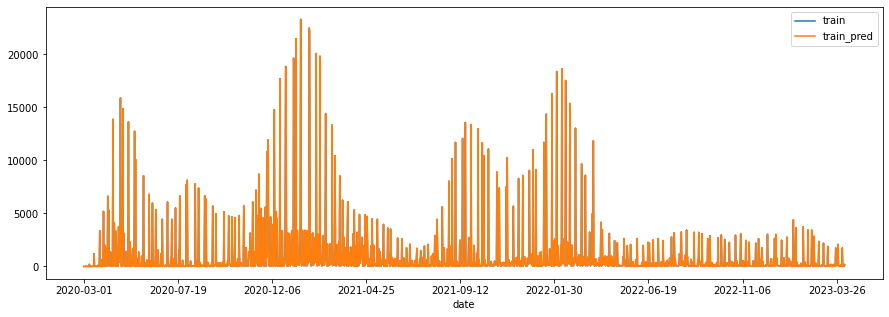

In [42]:
pd.concat([train['new_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

<Figure size 1080x720 with 0 Axes>

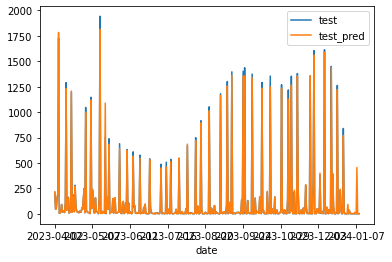

In [43]:
test_pred=pd.DataFrame(model.predict(test.drop('new_deaths', axis=1)), columns=['yhat'], index=test.index)
plt.figure(figsize=(15, 10))
pd.concat([test['new_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [44]:

metrics_df = pd.DataFrame()
metrics_df = pd.DataFrame(columns=['Model','MAPE'])
metrics_df

,Model,MAPE


In [45]:
actuals = test['new_deaths'] + 1
predictions = test_pred['yhat'] + 1
mape = mean_absolute_percentage_error(actuals, predictions) * 100
metrics_df.loc[len(metrics_df)] = ['base xgb', mape]

In [46]:
import optuna
import sklearn.datasets
import sklearn.metrics

In [47]:

# Assuming you have 'train' and 'test' DataFrames with the same features
# and 'target' is the target variable

def objective(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'objective': 'reg:squarederror',  # Assuming it's a regression task
        'eval_metric': 'mae',  # Using Mean Absolute Error as the evaluation metric
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
   
    }

    bst = xgb.train(param, xgb.DMatrix(train.drop('new_deaths', axis=1), label=train['new_deaths']))
    preds = bst.predict(xgb.DMatrix(test.drop('new_deaths', axis=1)))
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.mean_absolute_error(test['new_deaths'], pred_labels)
    return accuracy

# Assuming 'train' and 'test' are DataFrames with the same features
# and 'target' is the target variable
study = optuna.create_study(direction='minimize')  # Use 'minimize' for Mean Absolute Percentage Error
study.optimize(objective, n_trials=10)

# Access the best parameters
best_params = study.best_params
print("Best Params:", best_params)


[I 2024-02-24 16:43:58,182] A new study created in memory with name: no-name-f1ac840e-bec2-4288-ad2b-280a310863fb


[16:43:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:43:58,775] Trial 0 finished with value: 13.153086419753086 and parameters: {'n_estimators': 262, 'learning_rate': 0.2954266038911406, 'max_depth': 10}. Best is trial 0 with value: 13.153086419753086.


[16:43:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:43:59,093] Trial 1 finished with value: 42.98518518518519 and parameters: {'n_estimators': 287, 'learning_rate': 0.11439017012685083, 'max_depth': 7}. Best is trial 0 with value: 13.153086419753086.


[16:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:43:59,394] Trial 2 finished with value: 8.879012345679012 and parameters: {'n_estimators': 105, 'learning_rate': 0.33336766434214277, 'max_depth': 9}. Best is trial 2 with value: 8.879012345679012.
[I 2024-02-24 16:43:59,567] Trial 3 finished with value: 31.133333333333333 and parameters: {'n_estimators': 271, 'learning_rate': 0.14338563893814668, 'max_depth': 7}. Best is trial 2 with value: 8.879012345679012.


[16:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[16:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:43:59,725] Trial 4 finished with value: 10.37283950617284 and parameters: {'n_estimators': 253, 'learning_rate': 0.3044740876039758, 'max_depth': 6}. Best is trial 2 with value: 8.879012345679012.
[I 2024-02-24 16:43:59,896] Trial 5 finished with value: 25.65679012345679 and parameters: {'n_estimators': 162, 'learning_rate': 0.17008376555936314, 'max_depth': 7}. Best is trial 2 with value: 8.879012345679012.


[16:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[16:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:44:00,249] Trial 6 finished with value: 12.432098765432098 and parameters: {'n_estimators': 217, 'learning_rate': 0.4857096492541926, 'max_depth': 10}. Best is trial 2 with value: 8.879012345679012.
[I 2024-02-24 16:44:00,472] Trial 7 finished with value: 30.56543209876543 and parameters: {'n_estimators': 218, 'learning_rate': 0.148235782709183, 'max_depth': 9}. Best is trial 2 with value: 8.879012345679012.


[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:44:00,661] Trial 8 finished with value: 21.703703703703702 and parameters: {'n_estimators': 278, 'learning_rate': 0.20238527501946604, 'max_depth': 6}. Best is trial 2 with value: 8.879012345679012.


[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:44:00,920] Trial 9 finished with value: 22.377777777777776 and parameters: {'n_estimators': 214, 'learning_rate': 0.18591442938297534, 'max_depth': 9}. Best is trial 2 with value: 8.879012345679012.


Best Params: {'n_estimators': 105, 'learning_rate': 0.33336766434214277, 'max_depth': 9}


In [48]:
model = xgb.XGBRegressor(n_estimators = 65, learning_rate = 0.3210929352407252, max_depth = 10)
model.fit(train.drop('new_deaths', axis=1), train['new_deaths']);

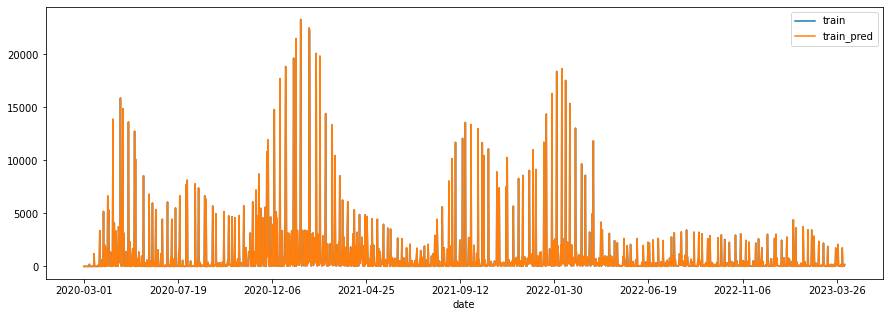

In [49]:
train_pred=pd.DataFrame(model.predict(train.drop('new_deaths', axis=1)), columns=['yhat'], index=train.index)
train_pred.head()
pd.concat([train['new_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

<Figure size 1080x720 with 0 Axes>

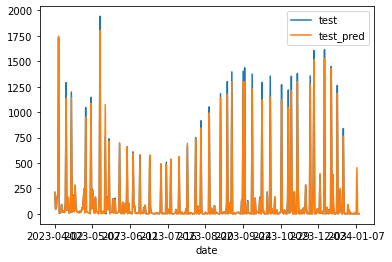

In [50]:
test_pred=pd.DataFrame(model.predict(test.drop('new_deaths', axis=1)), columns=['yhat'], index=test.index)
plt.figure(figsize=(15, 10))
pd.concat([test['new_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [51]:
test_pred

,yhat
date,
2023-04-02,212.238846
2023-04-02,45.536182
2023-04-09,52.380371
2023-04-09,169.841690
2023-04-09,201.076065
...,...
2024-01-07,-0.335079
2024-01-07,453.576691
2024-01-14,-0.042091


In [52]:
import pandas as pd
actuals = test['new_deaths'] + 1
predictions = test_pred['yhat'] + 1
mape = mean_absolute_percentage_error(actuals, predictions) * 100
row = {'Model': 'xgb with tuning 1', 'MAPE': mape}
metrics_df.loc[len(metrics_df)] = row

In [53]:
metrics_df

,Model,MAPE
0,base xgb,153.679716
1,xgb with tuning 1,145.642603


In [54]:
def objective(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'objective': 'reg:squarederror',  # Assuming it's a regression task
        'eval_metric': 'mae',  # Using Mean Absolute Error as the evaluation metric
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
   
    }

    bst = xgb.train(param, xgb.DMatrix(train.drop('new_deaths', axis=1), label=train['new_deaths']))
    preds = bst.predict(xgb.DMatrix(test.drop('new_deaths', axis=1)))
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.mean_absolute_error(test['new_deaths'], pred_labels)
    return accuracy

# Assuming 'train' and 'test' are DataFrames with the same features
# and 'target' is the target variable
study = optuna.create_study(direction='minimize')  # Use 'minimize' for Mean Absolute Percentage Error
study.optimize(objective, n_trials=10)

# Access the best parameters
best_params = study.best_params
print("Best Params:", best_params)


[I 2024-02-24 16:46:12,345] A new study created in memory with name: no-name-57e68f11-8bc7-4916-8873-36c1a8a80ddb


[16:46:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:46:13,145] Trial 0 finished with value: 25.419753086419753 and parameters: {'n_estimators': 63, 'learning_rate': 0.19910257378421634, 'max_depth': 5}. Best is trial 0 with value: 25.419753086419753.
[I 2024-02-24 16:46:13,389] Trial 1 finished with value: 27.076543209876544 and parameters: {'n_estimators': 160, 'learning_rate': 0.2803021901619364, 'max_depth': 4}. Best is trial 0 with value: 25.419753086419753.


[16:46:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[16:46:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:46:13,671] Trial 2 finished with value: 50.28888888888889 and parameters: {'n_estimators': 277, 'learning_rate': 0.10565025382669839, 'max_depth': 5}. Best is trial 0 with value: 25.419753086419753.


[16:46:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:46:13,923] Trial 3 finished with value: 37.77037037037037 and parameters: {'n_estimators': 243, 'learning_rate': 0.12445081487330438, 'max_depth': 8}. Best is trial 0 with value: 25.419753086419753.


[16:46:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:46:14,353] Trial 4 finished with value: 11.101234567901235 and parameters: {'n_estimators': 218, 'learning_rate': 0.32056552659040494, 'max_depth': 8}. Best is trial 4 with value: 11.101234567901235.


[16:46:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:46:14,733] Trial 5 finished with value: 44.51111111111111 and parameters: {'n_estimators': 255, 'learning_rate': 0.18141256125798466, 'max_depth': 4}. Best is trial 4 with value: 11.101234567901235.


[16:46:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:46:15,016] Trial 6 finished with value: 14.380246913580248 and parameters: {'n_estimators': 188, 'learning_rate': 0.4831942607867988, 'max_depth': 7}. Best is trial 4 with value: 11.101234567901235.
[I 2024-02-24 16:46:15,261] Trial 7 finished with value: 13.555555555555555 and parameters: {'n_estimators': 249, 'learning_rate': 0.44217292351292226, 'max_depth': 7}. Best is trial 4 with value: 11.101234567901235.


[16:46:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:46:15,481] Trial 8 finished with value: 43.24938271604938 and parameters: {'n_estimators': 57, 'learning_rate': 0.1268615664836391, 'max_depth': 5}. Best is trial 4 with value: 11.101234567901235.


[16:46:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-02-24 16:46:15,640] Trial 9 finished with value: 23.530864197530864 and parameters: {'n_estimators': 110, 'learning_rate': 0.34964684682798736, 'max_depth': 4}. Best is trial 4 with value: 11.101234567901235.


[16:46:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Best Params: {'n_estimators': 218, 'learning_rate': 0.32056552659040494, 'max_depth': 8}


In [ ]:
model = xgb.XGBRegressor(n_estimators = 65, learning_rate = 0.3210929352407252, max_depth = 10)
model.fit(train.drop('new_deaths', axis=1), train['new_deaths']);

train_pred=pd.DataFrame(model.predict(train.drop('new_deaths', axis=1)), columns=['yhat'], index=train.index)
train_pred.head()
pd.concat([train['new_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])